In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import tensorflow as tf

In [2]:
import pandas as pd

df = pd.read_excel('univ_data.xlsx', index_col=0, engine='openpyxl')

## 데이터셋 구성하기

In [3]:
import numpy as np


x = df.loc[:, 'GiftEd1':'Leisure4']
x = MinMaxScaler().fit_transform(x) #스케일링
x_a = df.loc[:, 'Sex_1.0':'Dream5_2.0'] #더미형 변수들은 스케일링에서 제외
x = np.concatenate((x, x_a.to_numpy()), axis=1) # 데이터셋 구성 완료
y = df.loc[:, 'CollegeMJ_1.0':'CollegeMJ_2.0'].to_numpy() # 출력 데이터
n_rows, n_cols = x.shape
print(n_rows, n_cols)

6908 111


In [4]:
# x, y의 속성이 궁금하다면 다음 함수를 실행해 볼 수 있다.
type(x)

numpy.ndarray

In [5]:
# k겹 교차 검증
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

n_fold = 5 #5개의 데이터셋으로 나눈다는 의미임.
skf = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state=42)
y_again = np.array([1 if i[0]==0 else 2 for i in y]) #비이공계열 1, 이공계열 2

## 모델 구성하기

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(units=111, input_dim=6908, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax')) #출력계층: 2차원 행렬이 출력값(0은 비이공계, 1은 이공계임)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 111)               766899    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                7168      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 775,141
Trainable params: 775,141
Non-trainable params: 0
_________________________________________________________________


In [8]:
model = Sequential()
model.add(Dense(units=111, input_dim=6908, activation='relu'))
model.add((Dropout(0.2)))
model.add(Dense(64, activation='relu'))
model.add((Dropout(0.2)))
model.add(Dense(16, activation='relu'))
model.add((Dropout(0.2)))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 111)               766899    
_________________________________________________________________
dropout (Dropout)            (None, 111)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                7168      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                

## 교차 검증 및 모델 학습하기

In [9]:
from keras import regularizers
from keras import initializers
from keras.constraints import max_norm
from keras.layers import LeakyReLU
from tensorflow.keras import layers, activations

# 모델을 구성하기 위한 함수
def run_model(rows, cols, l1_val=0.001, drop1=0.2, drop2=0.2):
    lval = l1_val
    dr_rate1 = drop1
    dr_rate2 = drop2
    
    #모델 구축
    model = Sequential()
    #입력 계층, Relu는 활성화함수, L1 정규화를 포함함
    model.add(Dense(units=rows, input_dim=cols, activation='relu', kernel_regularizer=regularizers.l1(lval))) 
    
    #입력계층: 노드(n_rows), 입력 피처(n_cols), 활성화함수는 RELU 사용.
    model.add(Dropout(dr_rate1))
    model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l1(lval)))
    model.add(Dropout(dr_rate2))
    model.add(Dense(units=2, activation='softmax')) #출력계층: 2차원 행렬이 출력값(0은 비이공계, 1은 이공계임)
    
    return model

In [10]:
%%time

accuracy = []
histories = []

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)

for train, test in skf.split(x, y_again):
    model = run_model(n_rows, n_cols, l1_val=0.001, drop1=0.5, drop2=0.5)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', metrics=['accuracy']) 
    histories.append(model.fit(
        x[train], y[train], epochs=1000, batch_size=500, 
        callbacks=[early_stopping_callback], validation_split=0.25, verbose=1))
    accuracy.append("%.2f" % (model.evaluate(x[test], y[test])[1]*100))
    
print('%.f fold accuracy:' % n_fold, accuracy)

Epoch 1/1000
9/9 [==============================] - 1s 25ms/step - loss: 14.5535 - accuracy: 0.5946 - val_loss: 9.6738 - val_accuracy: 0.5543
Epoch 2/1000
9/9 [==============================] - 0s 10ms/step - loss: 7.1970 - accuracy: 0.6028 - val_loss: 4.2893 - val_accuracy: 0.5543
Epoch 3/1000
9/9 [==============================] - 0s 10ms/step - loss: 3.1122 - accuracy: 0.6028 - val_loss: 2.0771 - val_accuracy: 0.5543
Epoch 4/1000
9/9 [==============================] - 0s 11ms/step - loss: 1.9691 - accuracy: 0.6026 - val_loss: 1.6944 - val_accuracy: 0.5543
Epoch 5/1000
9/9 [==============================] - 0s 11ms/step - loss: 1.4106 - accuracy: 0.6026 - val_loss: 1.2192 - val_accuracy: 0.5543
Epoch 6/1000
9/9 [==============================] - 0s 11ms/step - loss: 1.1116 - accuracy: 0.6026 - val_loss: 1.0097 - val_accuracy: 0.5543
Epoch 7/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.9498 - accuracy: 0.6026 - val_loss: 0.9124 - val_accuracy: 0.5543
Epoch 8/1000

Epoch 59/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7555 - accuracy: 0.7201 - val_loss: 0.7728 - val_accuracy: 0.6903
Epoch 60/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7503 - accuracy: 0.7244 - val_loss: 0.7742 - val_accuracy: 0.6896
Epoch 61/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7532 - accuracy: 0.7189 - val_loss: 0.7734 - val_accuracy: 0.6874
Epoch 62/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7490 - accuracy: 0.7232 - val_loss: 0.7724 - val_accuracy: 0.6910
Epoch 63/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7512 - accuracy: 0.7232 - val_loss: 0.7734 - val_accuracy: 0.6939
Epoch 64/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7458 - accuracy: 0.7215 - val_loss: 0.7746 - val_accuracy: 0.6918
Epoch 65/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7498 - accuracy: 0.7239 - val_loss: 0.7717 - val_accuracy: 0.6939
Epoch 

9/9 [==============================] - 0s 11ms/step - loss: 0.7407 - accuracy: 0.7283 - val_loss: 0.7689 - val_accuracy: 0.6925
Epoch 174/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7412 - accuracy: 0.7295 - val_loss: 0.7658 - val_accuracy: 0.7026
Epoch 175/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7391 - accuracy: 0.7244 - val_loss: 0.7666 - val_accuracy: 0.6918
Epoch 176/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7387 - accuracy: 0.7307 - val_loss: 0.7657 - val_accuracy: 0.7004
Epoch 177/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7358 - accuracy: 0.7331 - val_loss: 0.7664 - val_accuracy: 0.6910
Epoch 178/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7401 - accuracy: 0.7333 - val_loss: 0.7673 - val_accuracy: 0.6903
Epoch 179/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7433 - accuracy: 0.7194 - val_loss: 0.7706 - val_accuracy: 0.6889
Epoch 180/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7350 - accuracy: 0.7321 - val_loss: 0.7607 - val_accuracy: 0.7033
Epoch 288/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7329 - accuracy: 0.7305 - val_loss: 0.7633 - val_accuracy: 0.6918
Epoch 289/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7364 - accuracy: 0.7317 - val_loss: 0.7609 - val_accuracy: 0.6896
Epoch 290/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7331 - accuracy: 0.7235 - val_loss: 0.7647 - val_accuracy: 0.6896
Epoch 291/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7295 - accuracy: 0.7343 - val_loss: 0.7603 - val_accuracy: 0.6983
Epoch 292/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7379 - accuracy: 0.7247 - val_loss: 0.7658 - val_accuracy: 0.6903
Epoch 293/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7369 - accuracy: 0.7244 - val_loss: 0.7621 - val_accuracy: 0.7026
Epoch 294/1000

9/9 [==============================] - 0s 10ms/step - loss: 0.7281 - accuracy: 0.7288 - val_loss: 0.7757 - val_accuracy: 0.6910
Epoch 402/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7330 - accuracy: 0.7331 - val_loss: 0.7616 - val_accuracy: 0.7012
Epoch 403/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7333 - accuracy: 0.7333 - val_loss: 0.7596 - val_accuracy: 0.6990
Epoch 404/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7314 - accuracy: 0.7297 - val_loss: 0.7631 - val_accuracy: 0.6925
Epoch 405/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7290 - accuracy: 0.7358 - val_loss: 0.7602 - val_accuracy: 0.6954
Epoch 406/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7286 - accuracy: 0.7353 - val_loss: 0.7642 - val_accuracy: 0.6910
Epoch 407/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7303 - accuracy: 0.7319 - val_loss: 0.7642 - val_accuracy: 0.6983
Epoch 408/1000

Epoch 19/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.7820 - accuracy: 0.6984 - val_loss: 0.8086 - val_accuracy: 0.6751
Epoch 20/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.7806 - accuracy: 0.7029 - val_loss: 0.8093 - val_accuracy: 0.6686
Epoch 21/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.7830 - accuracy: 0.7109 - val_loss: 0.8054 - val_accuracy: 0.6766
Epoch 22/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7784 - accuracy: 0.7104 - val_loss: 0.8032 - val_accuracy: 0.6758
Epoch 23/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7746 - accuracy: 0.7162 - val_loss: 0.8078 - val_accuracy: 0.6679
Epoch 24/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7757 - accuracy: 0.7165 - val_loss: 0.7991 - val_accuracy: 0.6918
Epoch 25/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7762 - accuracy: 0.7092 - val_loss: 0.7958 - val_accuracy: 0.6910
Epoch 

Epoch 77/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7529 - accuracy: 0.7300 - val_loss: 0.7665 - val_accuracy: 0.6939
Epoch 78/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7502 - accuracy: 0.7276 - val_loss: 0.7712 - val_accuracy: 0.6881
Epoch 79/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7435 - accuracy: 0.7285 - val_loss: 0.7661 - val_accuracy: 0.6961
Epoch 80/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7487 - accuracy: 0.7317 - val_loss: 0.7678 - val_accuracy: 0.6910
Epoch 81/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7536 - accuracy: 0.7285 - val_loss: 0.7669 - val_accuracy: 0.6918
Epoch 82/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7470 - accuracy: 0.7280 - val_loss: 0.7679 - val_accuracy: 0.6881
Epoch 83/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7467 - accuracy: 0.7254 - val_loss: 0.7661 - val_accuracy: 0.6918
Epoch 

9/9 [==============================] - 0s 11ms/step - loss: 0.7386 - accuracy: 0.7305 - val_loss: 0.7635 - val_accuracy: 0.6874
Epoch 192/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7359 - accuracy: 0.7266 - val_loss: 0.7576 - val_accuracy: 0.7012
Epoch 193/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7325 - accuracy: 0.7358 - val_loss: 0.7621 - val_accuracy: 0.6867
Epoch 194/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7372 - accuracy: 0.7305 - val_loss: 0.7637 - val_accuracy: 0.6903
Epoch 195/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7348 - accuracy: 0.7355 - val_loss: 0.7621 - val_accuracy: 0.6867
Epoch 196/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7368 - accuracy: 0.7276 - val_loss: 0.7577 - val_accuracy: 0.6990
Epoch 197/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7389 - accuracy: 0.7317 - val_loss: 0.7660 - val_accuracy: 0.6845
Epoch 198/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7321 - accuracy: 0.7247 - val_loss: 0.7552 - val_accuracy: 0.7069
Epoch 306/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7405 - accuracy: 0.7249 - val_loss: 0.7694 - val_accuracy: 0.6802
Epoch 307/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7441 - accuracy: 0.7273 - val_loss: 0.7577 - val_accuracy: 0.7012
Epoch 308/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7340 - accuracy: 0.7292 - val_loss: 0.7593 - val_accuracy: 0.6939
Epoch 309/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7342 - accuracy: 0.7365 - val_loss: 0.7581 - val_accuracy: 0.6997
Epoch 310/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7335 - accuracy: 0.7278 - val_loss: 0.7603 - val_accuracy: 0.6874
Epoch 311/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7330 - accuracy: 0.7300 - val_loss: 0.7582 - val_accuracy: 0.6961
Epoch 312/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7620 - accuracy: 0.7215 - val_loss: 0.7949 - val_accuracy: 0.6932
Epoch 28/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7646 - accuracy: 0.7242 - val_loss: 0.7980 - val_accuracy: 0.6816
Epoch 29/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7621 - accuracy: 0.7242 - val_loss: 0.8061 - val_accuracy: 0.6592
Epoch 30/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7714 - accuracy: 0.7097 - val_loss: 0.8037 - val_accuracy: 0.6766
Epoch 31/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7665 - accuracy: 0.7196 - val_loss: 0.7969 - val_accuracy: 0.6932
Epoch 32/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7698 - accuracy: 0.7314 - val_loss: 0.7974 - val_accuracy: 0.6795
Epoch 33/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7584 - accuracy: 0.7302 - val_loss: 0.7923 - val_accuracy: 0.6954
Epoch 34/1000
9/9 [=

Epoch 85/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7467 - accuracy: 0.7312 - val_loss: 0.7755 - val_accuracy: 0.6939
Epoch 86/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7431 - accuracy: 0.7239 - val_loss: 0.7930 - val_accuracy: 0.6700
Epoch 87/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7454 - accuracy: 0.7266 - val_loss: 0.7776 - val_accuracy: 0.6939
Epoch 88/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7403 - accuracy: 0.7302 - val_loss: 0.7781 - val_accuracy: 0.6925
Epoch 89/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7445 - accuracy: 0.7242 - val_loss: 0.7786 - val_accuracy: 0.6925
Epoch 90/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7459 - accuracy: 0.7295 - val_loss: 0.7760 - val_accuracy: 0.6896
Epoch 91/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7414 - accuracy: 0.7302 - val_loss: 0.7757 - val_accuracy: 0.6910
Epoch 

9/9 [==============================] - 0s 11ms/step - loss: 0.7382 - accuracy: 0.7244 - val_loss: 0.7751 - val_accuracy: 0.6831
Epoch 200/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7339 - accuracy: 0.7297 - val_loss: 0.7701 - val_accuracy: 0.6939
Epoch 201/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7337 - accuracy: 0.7312 - val_loss: 0.7727 - val_accuracy: 0.6896
Epoch 202/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7413 - accuracy: 0.7280 - val_loss: 0.7735 - val_accuracy: 0.6802
Epoch 203/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7325 - accuracy: 0.7319 - val_loss: 0.7687 - val_accuracy: 0.6961
Epoch 204/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7406 - accuracy: 0.7317 - val_loss: 0.7741 - val_accuracy: 0.6831
Epoch 205/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7370 - accuracy: 0.7348 - val_loss: 0.7707 - val_accuracy: 0.6910
Epoch 206/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7313 - accuracy: 0.7384 - val_loss: 0.7680 - val_accuracy: 0.6874
Epoch 314/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7289 - accuracy: 0.7285 - val_loss: 0.7827 - val_accuracy: 0.6744
Epoch 315/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7278 - accuracy: 0.7360 - val_loss: 0.7717 - val_accuracy: 0.6874
Epoch 316/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7395 - accuracy: 0.7300 - val_loss: 0.7686 - val_accuracy: 0.6874
Epoch 317/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7295 - accuracy: 0.7379 - val_loss: 0.7739 - val_accuracy: 0.6831
Epoch 318/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7302 - accuracy: 0.7408 - val_loss: 0.7861 - val_accuracy: 0.6708
Epoch 319/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7321 - accuracy: 0.7297 - val_loss: 0.7687 - val_accuracy: 0.6918
Epoch 320/1000

Epoch 9/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.8407 - accuracy: 0.6055 - val_loss: 0.8560 - val_accuracy: 0.5449
Epoch 10/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.8220 - accuracy: 0.6055 - val_loss: 0.8465 - val_accuracy: 0.5449
Epoch 11/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.8151 - accuracy: 0.6055 - val_loss: 0.8394 - val_accuracy: 0.5449
Epoch 12/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.8023 - accuracy: 0.6055 - val_loss: 0.8318 - val_accuracy: 0.5449
Epoch 13/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7971 - accuracy: 0.6058 - val_loss: 0.8277 - val_accuracy: 0.5449
Epoch 14/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7939 - accuracy: 0.6323 - val_loss: 0.8259 - val_accuracy: 0.6302
Epoch 15/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7895 - accuracy: 0.6823 - val_loss: 0.8227 - val_accuracy: 0.6331
Epoch 1

Epoch 67/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7519 - accuracy: 0.7271 - val_loss: 0.7801 - val_accuracy: 0.6852
Epoch 68/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7505 - accuracy: 0.7233 - val_loss: 0.7820 - val_accuracy: 0.6795
Epoch 69/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7501 - accuracy: 0.7247 - val_loss: 0.7799 - val_accuracy: 0.6780
Epoch 70/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7458 - accuracy: 0.7327 - val_loss: 0.7786 - val_accuracy: 0.6881
Epoch 71/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7506 - accuracy: 0.7238 - val_loss: 0.7776 - val_accuracy: 0.6867
Epoch 72/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7492 - accuracy: 0.7269 - val_loss: 0.7775 - val_accuracy: 0.6874
Epoch 73/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7436 - accuracy: 0.7250 - val_loss: 0.7794 - val_accuracy: 0.6809
Epoch 

9/9 [==============================] - 0s 11ms/step - loss: 0.7387 - accuracy: 0.7279 - val_loss: 0.7747 - val_accuracy: 0.6816
Epoch 182/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7384 - accuracy: 0.7317 - val_loss: 0.7708 - val_accuracy: 0.6896
Epoch 183/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7383 - accuracy: 0.7245 - val_loss: 0.7835 - val_accuracy: 0.6744
Epoch 184/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7454 - accuracy: 0.7310 - val_loss: 0.7736 - val_accuracy: 0.6845
Epoch 185/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7367 - accuracy: 0.7296 - val_loss: 0.7712 - val_accuracy: 0.6881
Epoch 186/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7365 - accuracy: 0.7339 - val_loss: 0.7730 - val_accuracy: 0.6860
Epoch 187/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7404 - accuracy: 0.7320 - val_loss: 0.7727 - val_accuracy: 0.6838
Epoch 188/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7310 - accuracy: 0.7361 - val_loss: 0.7718 - val_accuracy: 0.6838
Epoch 296/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7281 - accuracy: 0.7382 - val_loss: 0.7764 - val_accuracy: 0.6773
Epoch 297/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7328 - accuracy: 0.7327 - val_loss: 0.7665 - val_accuracy: 0.6860
Epoch 298/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7333 - accuracy: 0.7337 - val_loss: 0.7664 - val_accuracy: 0.6961
Epoch 299/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7357 - accuracy: 0.7262 - val_loss: 0.7738 - val_accuracy: 0.6773
Epoch 300/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7334 - accuracy: 0.7235 - val_loss: 0.7730 - val_accuracy: 0.6838
Epoch 301/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7411 - accuracy: 0.7252 - val_loss: 0.7647 - val_accuracy: 0.6918
Epoch 302/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7355 - accuracy: 0.7194 - val_loss: 0.7700 - val_accuracy: 0.6867
Epoch 410/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7375 - accuracy: 0.7264 - val_loss: 0.7712 - val_accuracy: 0.6881
Epoch 411/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7292 - accuracy: 0.7305 - val_loss: 0.7694 - val_accuracy: 0.6845
Epoch 412/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7272 - accuracy: 0.7274 - val_loss: 0.7619 - val_accuracy: 0.6939
Epoch 413/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7294 - accuracy: 0.7312 - val_loss: 0.7736 - val_accuracy: 0.6845
Epoch 414/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7289 - accuracy: 0.7303 - val_loss: 0.7656 - val_accuracy: 0.6903
Epoch 415/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7288 - accuracy: 0.7366 - val_loss: 0.7771 - val_accuracy: 0.6773
Epoch 416/1000

Epoch 12/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.8026 - accuracy: 0.6048 - val_loss: 0.8317 - val_accuracy: 0.5478
Epoch 13/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7948 - accuracy: 0.6048 - val_loss: 0.8265 - val_accuracy: 0.5478
Epoch 14/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7919 - accuracy: 0.6113 - val_loss: 0.8234 - val_accuracy: 0.5478
Epoch 15/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7897 - accuracy: 0.6429 - val_loss: 0.8189 - val_accuracy: 0.6469
Epoch 16/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7857 - accuracy: 0.6825 - val_loss: 0.8170 - val_accuracy: 0.6425
Epoch 17/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7808 - accuracy: 0.6982 - val_loss: 0.8147 - val_accuracy: 0.6534
Epoch 18/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7772 - accuracy: 0.7011 - val_loss: 0.8127 - val_accuracy: 0.6628
Epoch 

Epoch 70/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7503 - accuracy: 0.7194 - val_loss: 0.7848 - val_accuracy: 0.6903
Epoch 71/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7544 - accuracy: 0.7146 - val_loss: 0.7852 - val_accuracy: 0.6860
Epoch 72/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7481 - accuracy: 0.7259 - val_loss: 0.7879 - val_accuracy: 0.6845
Epoch 73/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7440 - accuracy: 0.7262 - val_loss: 0.7809 - val_accuracy: 0.6889
Epoch 74/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7460 - accuracy: 0.7264 - val_loss: 0.7823 - val_accuracy: 0.6954
Epoch 75/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7465 - accuracy: 0.7177 - val_loss: 0.7837 - val_accuracy: 0.6845
Epoch 76/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7465 - accuracy: 0.7194 - val_loss: 0.7823 - val_accuracy: 0.6889
Epoch 

9/9 [==============================] - 0s 11ms/step - loss: 0.7408 - accuracy: 0.7242 - val_loss: 0.7767 - val_accuracy: 0.6939
Epoch 185/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7392 - accuracy: 0.7271 - val_loss: 0.7758 - val_accuracy: 0.6896
Epoch 186/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7368 - accuracy: 0.7303 - val_loss: 0.7779 - val_accuracy: 0.6896
Epoch 187/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7365 - accuracy: 0.7310 - val_loss: 0.7875 - val_accuracy: 0.6758
Epoch 188/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7314 - accuracy: 0.7327 - val_loss: 0.7784 - val_accuracy: 0.6867
Epoch 189/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7401 - accuracy: 0.7250 - val_loss: 0.7783 - val_accuracy: 0.6874
Epoch 190/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7341 - accuracy: 0.7276 - val_loss: 0.7796 - val_accuracy: 0.6852
Epoch 191/1000

9/9 [==============================] - 0s 11ms/step - loss: 0.7304 - accuracy: 0.7317 - val_loss: 0.7743 - val_accuracy: 0.6932
Epoch 299/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7303 - accuracy: 0.7310 - val_loss: 0.7832 - val_accuracy: 0.6780
Epoch 300/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7322 - accuracy: 0.7337 - val_loss: 0.7815 - val_accuracy: 0.6802
Epoch 301/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7304 - accuracy: 0.7341 - val_loss: 0.7746 - val_accuracy: 0.6838
Epoch 302/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.7284 - accuracy: 0.7353 - val_loss: 0.7805 - val_accuracy: 0.6823
Epoch 303/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.7306 - accuracy: 0.7346 - val_loss: 0.7770 - val_accuracy: 0.6852
Epoch 304/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.7241 - accuracy: 0.7358 - val_loss: 0.7877 - val_accuracy: 0.6729
Epoch 305/1000

In [11]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 6908)              773696    
_________________________________________________________________
dropout_11 (Dropout)         (None, 6908)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                442176    
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 130       
Total params: 1,216,002
Trainable params: 1,216,002
Non-trainable params: 0
_________________________________________________________________


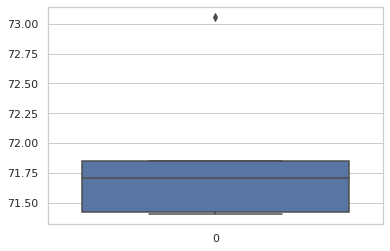

In [12]:
import seaborn as sns

sns.set_theme(style='whitegrid')
ax = sns.boxplot(data=accuracy, dodge=True)

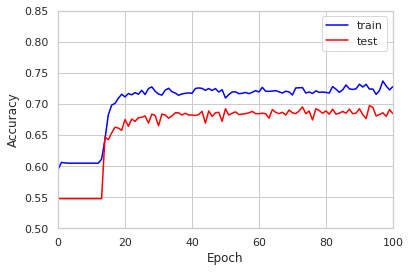

In [15]:
import matplotlib.pyplot as plt

i = accuracy.index(max(accuracy)) # 가장 accuracy가 높은 데이터를 활용하였음
y_acc = histories[i].history['accuracy']
y_val_acc = histories[i].history['val_accuracy']
x_len = np.arange(len(y_acc))

plt.plot(x_len, y_acc, c='blue', label='train')
plt.plot(x_len, y_val_acc, c='red', label='test')
plt.xlim([0, 100])
plt.ylim([0.50, 0.85])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 여러 모델을 비교하면서 ROC Curve 그리기

## 인공신경망을 통한 예측 확률 곡선을 통해 ROC 그리기

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)
y_test_pred = np.argmax(model.predict(x_test), axis=-1)
y_test_pred_probs = model.predict(x_test)

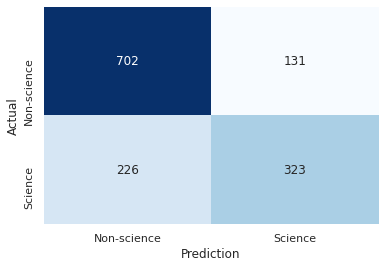

0.7416787264833574


In [21]:
y_t = [0 if i==1 else 1 for i, j in y_test] #출력 계층이 2차원이어서 이를 1차원으로 다시 수정하는 과정임
y_t_pred_probs = [1-i for i, j in y_test_pred_probs]

c_matrix = confusion_matrix(y_t, y_test_pred)
ax = sns.heatmap(c_matrix, annot=True, 
                 xticklabels=['Non-science', 'Science'], 
                 yticklabels=['Non-science', 'Science'],
                cbar=False, cmap='Blues', fmt='d')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')
plt.show()
plt.close()

print(metrics.accuracy_score(y_t, y_test_pred))

## 여러 개의 모형에 대한 비교

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

seed = 42

x_train, x_test, y_train, y_test = train_test_split(
    x, y_again, test_size=0.2, random_state=42)

classifier_names = ['LR', 'kNN', 'RBF SVM', 
                    'Random Forest', 'Boosted Trees']

classifiers = [LogisticRegression(random_state=seed, max_iter=10000),
               KNeighborsClassifier(5),
               SVC(gamma=2, C=1, random_state=seed),
               RandomForestClassifier(
                   max_depth=20, n_estimators=100, max_features=5, 
                   random_state=seed),
               GradientBoostingClassifier(
                   n_estimators=100, learning_rate=0.01,
                   max_depth=20, random_state=seed)]

In [84]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

acc = []

for i, models in enumerate(classifiers):
    scores = cross_val_score(
        models, x, y_again, cv=KFold(n_splits=5, shuffle=True), 
        scoring='accuracy')
    acc.append(scores)
    models.fit(x_train, y_train)
    y_pred = models.predict(x_test)
    #print(classifier_names[i])
    #print(metrics.classification_report(y_test, y_pred))    

CPU times: user 2min 17s, sys: 2min 12s, total: 4min 29s
Wall time: 1min 46s


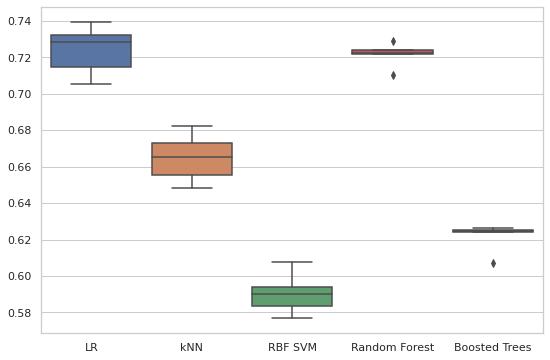

In [82]:
import seaborn as sns

plt.figure(figsize=(9, 6))
sns.set_theme(style='whitegrid')
ax = sns.boxplot(data=acc, dodge=True)
ax.set_xticklabels(classifier_names)
plt.show()

In [62]:
for i, models in enumerate(classifiers):
    y_pred = models.predict(x_test)
    print(classifier_names[i])
    print(metrics.classification_report(y_test, y_pred))

LR
              precision    recall  f1-score   support

           1       0.71      0.57      0.63       549
           2       0.75      0.85      0.79       833

    accuracy                           0.74      1382
   macro avg       0.73      0.71      0.71      1382
weighted avg       0.73      0.74      0.73      1382

kNN
              precision    recall  f1-score   support

           1       0.58      0.51      0.54       549
           2       0.70      0.76      0.73       833

    accuracy                           0.66      1382
   macro avg       0.64      0.63      0.64      1382
weighted avg       0.65      0.66      0.65      1382

RBF SVM
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       549
           2       0.60      1.00      0.75       833

    accuracy                           0.60      1382
   macro avg       0.30      0.50      0.38      1382
weighted avg       0.36      0.60      0.45      1382

Rand

/home/user/anaconda3/envs/nlp2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/nlp2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/nlp2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC를 사용해 분류기의 성능을 평가하는 헬퍼 함수
def TestROC(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(labels, predictions, pos_label=2)
    return fpr, tpr

# PR를 사용해 분류기의 성능을 평가하는 헬퍼 함수
def TestPR(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    
    p, r, _ = precision_recall_curve(labels, predictions, pos_label=2)
    return p, r

In [64]:
fp = []
tp = []
pr = []
rc = []

for i, models in enumerate(classifiers):
    f, t = TestROC(models, x_test, y_test)
    p, r = TestPR(models, x_test, y_test)
    fp.append(f)
    tp.append(t)
    pr.append(p)
    rc.append(r)

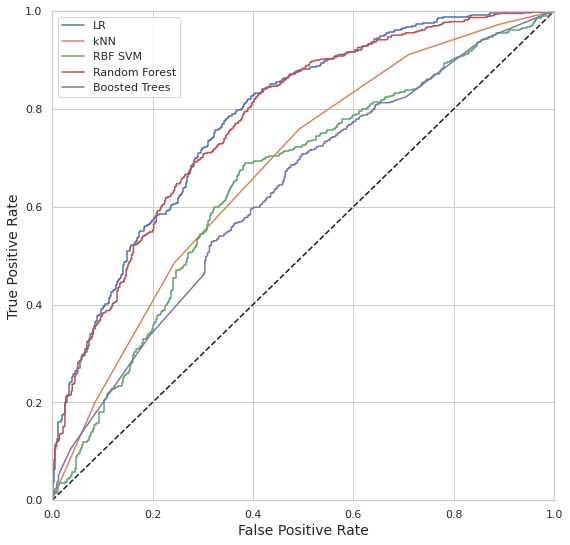

In [65]:
# ROC Curve

plt.figure(figsize=(9, 9))
plt.plot([0, 1], [0, 1], 'k--')

for i, name in enumerate(classifier_names):
    plt.plot(fp[i], tp[i], label=name)
    
plt.legend()
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

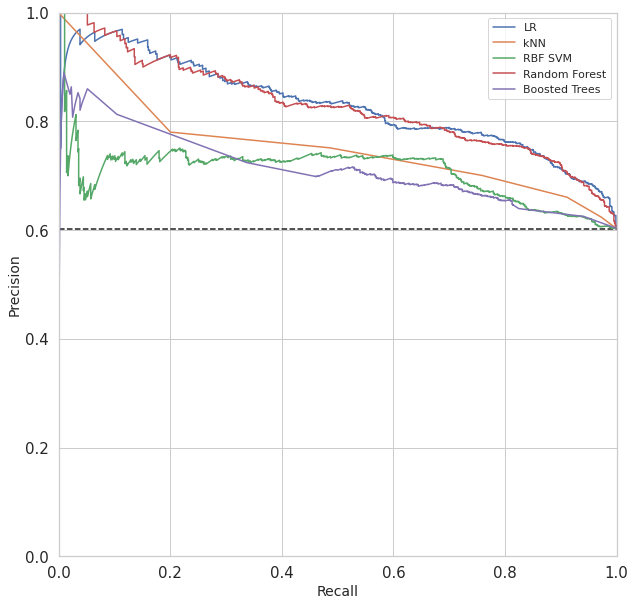

In [66]:
# Precision-Recall Curve
plt.figure(figsize=(10, 10))

no_skill = len(y_test[y_test == 2]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], 'k--')

for i, name in enumerate(classifier_names):
    plt.plot(rc[i], pr[i], label=name)
    
plt.legend()
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Select K Best

In [96]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

top_features = SelectKBest(chi2, k=10)

fit = top_features.fit(x_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
columns = pd.DataFrame(df.columns[:111])
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10, 'Score')  #print 20 best features

,Specs,Score
110,Dream5_2.0,251.091749
108,Dream4_2.0,228.546795
100,Sex_2.0,155.751690
99,Sex_1.0,137.696602
106,Dream3_2.0,125.681571
104,Dream2_2.0,121.598596
102,Dream1_2.0,93.735627
68,Efficacy5,72.442491
63,Motive5,66.023803
62,Motive4,62.115642


## SVM Linear

<AxesSubplot:>

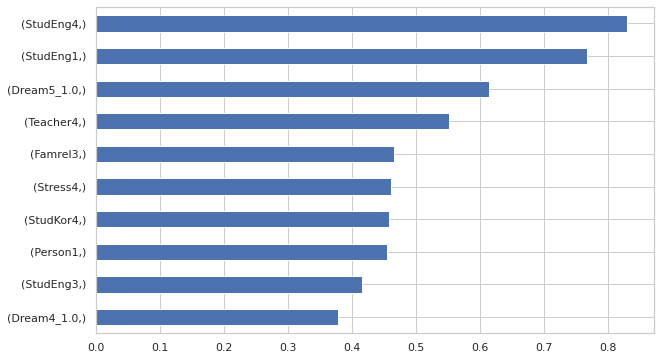

In [104]:
from matplotlib import pyplot as plt
from sklearn import svm

svm = svm.SVC(kernel='linear')
# Kernel type: ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, default=’rbf’
svm.fit(x_train, y_train)

pd.Series(
        svm.coef_[0], index=columns).nlargest(10).sort_values(
    ascending=True).plot(kind='barh', figsize=(10,6))

In [111]:
pd.Series(svm.coef_[0], index=columns).sort_values(ascending=False)

(StudEng4,)      0.829417
(StudEng1,)      0.766366
(Dream5_1.0,)    0.614048
(Teacher4,)      0.551476
(Famrel3,)       0.464813
                   ...   
(Motive4,)      -0.702215
(Score1,)       -0.753120
(Efficacy4,)    -0.767725
(Efficacy5,)    -0.812697
(StudMath4,)    -0.867248
Length: 111, dtype: float64

In [103]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = svm.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7272069464544139
              precision    recall  f1-score   support

           1       0.70      0.55      0.61       549
           2       0.74      0.85      0.79       833

    accuracy                           0.73      1382
   macro avg       0.72      0.70      0.70      1382
weighted avg       0.72      0.73      0.72      1382



## Common Functions

In [132]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

def DrawConfusionMat(t, p):
    c_matrix = confusion_matrix(t, p)
    plt.figure(figsize=(9, 9))
    ax = sns.heatmap(
        c_matrix, annot=True, xticklabels=['Non-science', 'Science'],
        yticklabels=['Non-science', 'Science'], cbar=False, cmap='Blues', 
        fmt='d')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Actual')
    plt.show()
    plt.clf()
    
def DrawROC(model, x, y, name, processed=False):
    if (processed==True):
        fpr = x
        tpr = y
    else:
        fpr, tpr = TestROC(model, x, y)
    
    plt.figure(figsize=(9, 9))
    plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()
    
def DrawPR(model, x, y, name, processed=False):
    if (processed==True):
        precision = x
        recall = y
    else:
        precision, recall = TestROC(model, x, y)
    
    no_skill = len(y_test[y_test == 1]) / len(y_test)

    plt.figure(figsize=(9, 9))
    plt.plot(recall, precision, label=name)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')
    plt.legend()
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# 모델 및 데이터를 입력하면 그에 대한 정확도를 계산해 주는 함수이다.
def CalculateAccuracy(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return mean(scores), std(scores)

# ROC를 사용해 분류기의 성능을 평가하는 헬퍼 함수
def TestROC(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = roc_curve(labels, predictions, pos_label=2)
    return fpr, tpr

# PR를 사용해 분류기의 성능을 평가하는 헬퍼 함수
def TestPR(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    
    p, r, _ = precision_recall_curve(labels, predictions)
    return p, r

## Random Forest

In [112]:
#랜덤 포레스트에서의 피처 추출 방법
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

seed = 1

clf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='entropy', # gini or entropy
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=seed, verbose=0,
            warm_start=False)
clf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=200, n_jobs=-1, random_state=1)

Accuracy: 0.7344428364688856


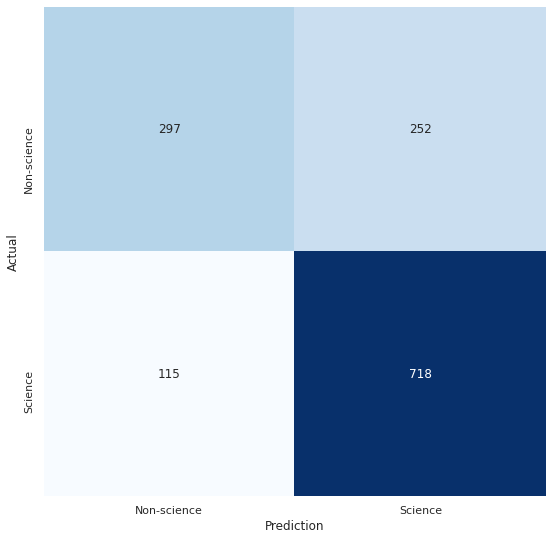

<Figure size 432x288 with 0 Axes>

In [116]:
y_pred = clf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

DrawConfusionMat(y_test, y_pred)

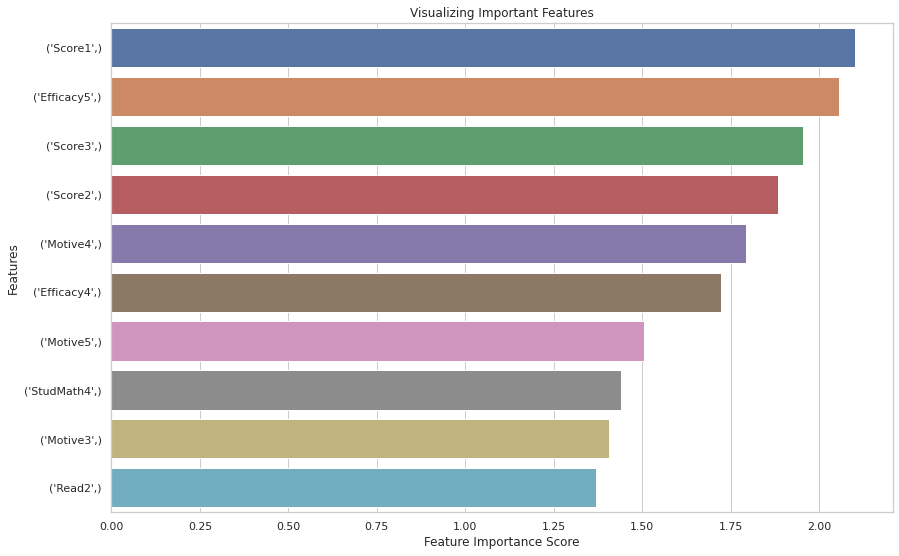

In [122]:
feature_imp = pd.Series(
    clf.feature_importances_*100, index=columns).nlargest(10).sort_values(
    ascending=False)

# Creating a bar plot
plt.figure(figsize=(14,9))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [121]:
sum(clf.feature_importances_)

1.0000000000000002

## Recurive Feature Elimination

In [123]:
%%time

# evaluate RFE for classification
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

rfe = Pipeline(
    steps=[('s', RFE(estimator=DecisionTreeClassifier(), 
                     n_features_to_select=10)),
                           ('m', DecisionTreeClassifier())], verbose=True)
rfe.fit(x_train, y_train)

[Pipeline] ................. (step 1 of 2) Processing s, total=   6.5s
[Pipeline] ................. (step 2 of 2) Processing m, total=   0.0s
CPU times: user 6.6 s, sys: 0 ns, total: 6.6 s
Wall time: 6.6 s


Pipeline(steps=[('s',
                 RFE(estimator=DecisionTreeClassifier(),
                     n_features_to_select=10)),
                ('m', DecisionTreeClassifier())],
         verbose=True)

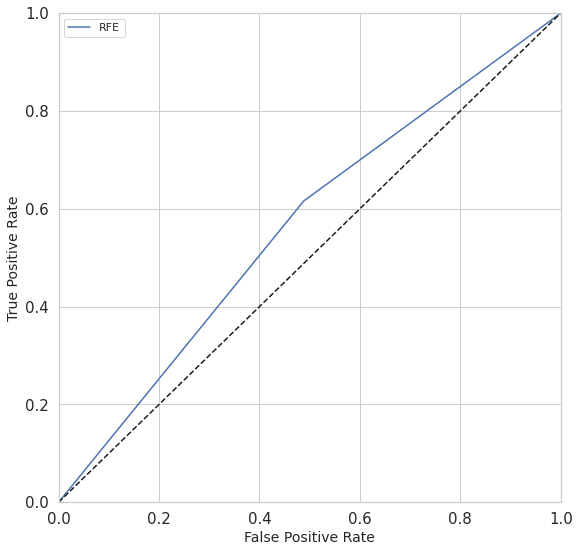

In [134]:
DrawROC(rfe, x_test, y_test, 'RFE')

## Sequential Forward Selection

In [136]:
%%time

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=5)
sfs = SFS(knn, k_features=10, forward=True, floating=False, verbose=2, scoring='accuracy', cv=5, n_jobs=-1)
sfs = sfs.fit(x_train, y_train)

print('\nSequential Forward Selection (k=10):')
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of 111 | elapsed:    4.2s remaining:   53.9s
[Parallel(n_jobs=-1)]: Done  64 out of 111 | elapsed:    4.4s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    4.8s finished

[2021-07-25 23:01:24] Features: 1/10 -- score: 0.6284828946184121[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of 110 | elapsed:    0.5s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  63 out of 110 | elapsed:    0.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    1.2s finished

[2021-07-25 23:01:26] Features: 2/10 -- score: 0.6442262279790202[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of 109 | elapsed:    0.6s remaining:   12.0s
[Parallel(n_jobs=-1)]: Done  60 out of 109 | elapsed:    0.8s remaining:    0.7s
[Parallel


Sequential Forward Selection (k=20):
('62', '65', '68', '86', '102', '103', '106', '108', '109', '110')
CV Score:
0.6793311677153822
CPU times: user 4.41 s, sys: 4.31 s, total: 8.71 s
Wall time: 16.1 s


[Parallel(n_jobs=-1)]: Done  99 out of 102 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.4s finished

[2021-07-25 23:01:36] Features: 10/10 -- score: 0.6793311677153822

In [150]:
f_names = list(sfs.k_feature_names_)
f_names = [int(i) for i in f_names]

print('\nSequential Forward Selection (k=10):')
print(columns.iloc[f_names])
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=10):
              0
62      Motive4
65    Efficacy2
68    Efficacy5
86       Extra1
102  Dream1_2.0
103  Dream2_1.0
106  Dream3_2.0
108  Dream4_2.0
109  Dream5_1.0
110  Dream5_2.0
CV Score:
0.6793311677153822


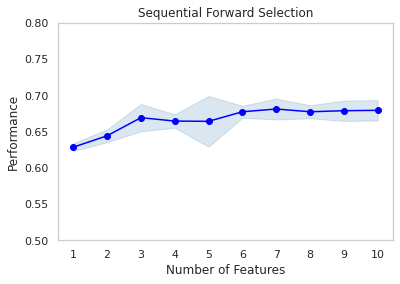

In [153]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.5, 0.8])
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()